# Script for scraping games from USAU website

Daniel Walton, 5/22/2019

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import collections
from bs4 import BeautifulSoup
from datetime import datetime

In [90]:
# Handy way for storing scores
Score = collections.namedtuple('Score', ['team_a', 'team_b'])

# Format for game logs
GameLog = collections.namedtuple('GameLog', ['level','name','team_a_name','team_b_name',\
                                             'score','winner','loser',\
                                             'child_a','child_b','parent'])

In [ ]:
"""
Querying the USAU website, like:

past/upcoming:  
https://play.usaultimate.org/events/tournament/?ViewAll=false&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

all events view:
https://play.usaultimate.org/events/tournament/?ViewAll=true&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

"""

In [3]:
# Background:
#
# To validate the model, we want to see if we can use end-of-regular-season power
# ratings to predict the outcomes of the post-season.
#
# So, we grab the final regular season rankings/power ratings and all games from the
# post-season.  The post season includes the conference championships (a.k.a. sectionals),
# regionals, and nationals.  Nationals hasn't happened yet, so we will just be looking at
# sectionals and regionals data for the most part.
#
# We will perform cross-validation to tune the only parameter in our model p_a_offense,
# the probability of the higher rated team scoring a point when the start on offense.
# This parameter is currently set at 0.8 based on a small amount of observed data.  
# But, we can see if there is a better value.  The 0.8 value is based on Nationals quality 
# teams.  Since, the ultimate goal is to be able to predict nationals outcomes,
# we may want to limit the scope of this so we aren't trying to fit the value with a
# bunch of weak teams where results can be *much* more variable.

In [412]:
# Dates to use
#
# Will use last rankings set before the post season for 2019.
# These rankings were posted April 4, 2019.  I grabbed them May 22, 2019.
# Name	Status	Rank Set	Create Date	Links
# 2019 College Men's - Rankings April 4 - Final Rankings
# 2019 College Women's - Rankings April 4 - Final Rankings
 
final_regular_season_rankings_date = datetime(2019, 4, 4)
last_day_before_college_nationals = datetime(2019, 5, 23)

start_date = final_regular_season_rankings_date
end_date = last_day_before_college_nationals

In [92]:
# New approach, just scrape rankings including href links for each team, 
# then go to each team's page and get all of their games.
# Each game will be double counted, but that's OK.

In [252]:
womens_ranking_html = r'FullTeamRankings_women.html'
mens_ranking_html   = r'FullTeamRankings_men.html'

In [265]:
def get_team_rankings_and_page_links(url):
    """
    Get the rankings data, including power ratings from a the USAU website.
    
    Returns a dataframe with the data.
    """
    columns = ['Rank', 'Team', 'Power Rating', 'Competition Level',
               'Gender Division', 'Competition Division', 'College Region', 
               'College Conference', 'Wins', 'Losses', 'Link']
    
    url_prefix = r'https://play.usaultimate.org'
    
    with open(url,"r") as file:
        soup = BeautifulSoup(file, 'lxml')
        parsed_table = soup.find_all('table')[0] 
        data = [[''.join(td.stripped_strings) for td in row.find_all('td')] + 
                [url_prefix + td.a['href'] for td in row.find_all('td') if td.find('a')]
                for row in parsed_table.find_all('tr')]
        df = pd.DataFrame(data[1:], columns=columns)
        df.drop(index=[len(df)-2, len(df)-1], inplace=True)  

    # Make certain columns numeric
    cols = ['Rank', 'Power Rating', 'Wins', 'Losses']
    df[cols] = df[cols].apply(pd.to_numeric)
    
    return df

In [261]:
#
# Test on women's rankings
#
url = r'FullTeamRankings_women.html'

df_womens = get_team_rankings_and_page_links(url)

print(df_womens.head())

print(df_womens.loc[0].Link)
print(df_womens.loc[len(df_womens)-1].Link)

  Rank                     Team Power Rating Competition Level  \
0    1           North Carolina         2324           College   
1    2     California-San Diego         2261           College   
2    3               Ohio State         2236           College   
3    4  Carleton College-Syzygy         2150           College   
4    5                Dartmouth         2080           College   

  Gender Division Competition Division  College Region  \
0           Women           Division I  Atlantic Coast   
1           Women           Division I       Southwest   
2           Women           Division I     Ohio Valley   
3           Women           Division I   North Central   
4           Women           Division I     New England   

         College Conference Wins Losses  \
0               Carolina DI   27      3   
1                  SoCal DI   36      3   
2                   Ohio DI   32      3   
3  Western North Central DI   26      5   
4    Greater New England DI   27      5

In [211]:
def str_to_score(score_string):
    """
    Convert a string to a score: '15-11' -> Score(team_a=15, team_b=11)
    
    Currently discards F - W (forfeit results)
    """
    
    numbers = score_string.split('-')
    if numbers[0]=='F ' and numbers[1]==' W':
        return np.nan 
    else:
        try:
            return Score(team_a=int(numbers[0]), team_b=int(numbers[1]))
        except:
            return np.nan

In [291]:
def get_team_game_scores(team_name, team_url, year, 
                         date_from=datetime(1900,1,1), 
                         date_to=datetime(2100,12,31)):
    """
    For a team name and team url (on USAU webpage), scrape the date, score, 
    and opponent into a pandas dataframe.
    
    Only return games in range [date_from, date_to], where date_from and date_to
    are datetime.datetime objects.
    
    Ignore games with F - W results and missing values.
    """
    # Read data
    df = pd.read_html(team_url)[1]
    
    # Rename columns
    df.rename(columns={0:'Date', 1:'Score', 2:'Opponent'}, inplace=True)
    
    # Drop rows that are actually tournament names
    rows_to_drop = [i for i in df.index.values if df.loc[i].Date==df.loc[i].Opponent]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Convert strings to scores
    df['Score']= df['Score'].apply(lambda x: str_to_score(x) if type(x)==str else np.nan)
    
    # Drop any nan results or F-W (forfeits?)
    df.dropna(subset=['Score'], inplace=True)
    
    # Change dates to datetime objects
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x+', '+str(year), '%B %d, %Y'))
    
    # Only dates in range
    rows_to_drop = [i for i in df.index.values if (df.loc[i].Date < date_from) or 
                    (df.loc[i].Date > date_to)]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Add column with team name
    df['Team'] = [team_name]*len(df.index)
    
    return df[['Date', 'Team', 'Opponent', 'Score']]

In [292]:
# Tests for get_team_scores
unc_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=udzbUQebhR1gq5fh0jyPE7aek4qofifkyNuGv56TTes%3d'
dartmouth_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=lPzPU9u%2fGPP%2bxoOe%2bowY%2bn8NfAdXmjbu%2bqbxMaHS4p0%3d'

df_unc = get_team_game_scores('North Carolina', unc_url, 2019, 
                              date_from=final_regular_season_rankings_date,
                              date_to=last_day_before_college_nationals)
df_dartmouth = get_team_game_scores('Dartmouth', dartmouth_url, 2019,
                              date_from=final_regular_season_rankings_date,
                              date_to=last_day_before_college_nationals)

print(df_unc)
print(df_dartmouth)

         Date            Team                   Opponent     Score
26 2019-04-13  North Carolina  North Carolina-Wilmington  (10, 11)
27 2019-04-13  North Carolina          Appalachian State   (13, 0)
28 2019-04-13  North Carolina                       Duke   (11, 3)
29 2019-04-13  North Carolina              East Carolina   (13, 0)
32 2019-04-27  North Carolina              James Madison   (13, 2)
33 2019-04-27  North Carolina                   American   (13, 3)
34 2019-04-27  North Carolina                       Duke   (12, 3)
35 2019-04-28  North Carolina                   Virginia   (13, 9)
36 2019-04-28  North Carolina             South Carolina   (12, 9)
37 2019-04-28  North Carolina                    Clemson   (15, 3)
         Date       Team           Opponent     Score
24 2019-04-13  Dartmouth              Maine   (13, 2)
25 2019-04-13  Dartmouth      Massachusetts   (12, 7)
26 2019-04-13  Dartmouth            Vermont  (13, 10)
27 2019-04-13  Dartmouth       Rhode Island   (

In [420]:
def get_all_scores_all_teams(ranking_url, year, 
                             date_from=datetime(1900,1,1), 
                             date_to=datetime(2100,1,1), 
                             rank_from=1, rank_to=np.inf, 
                             pause_time = 0):
    """
    Gets all scores from all games played by all teams in the rankings.
    
    Returns a dataframe with game data.
    
    Games *should* only appear once.  
    """
    
    rankings_data = get_team_rankings_and_page_links(ranking_url)
    
    list_of_df_to_concat = [] #Store each df and concat at the end
    
    for i in rankings_data.index.values:
        row = rankings_data.loc[i]
        
        # Is this team ranked in the desired range?
        # If so, then scrape data from the team page and append
        if (row.Rank >= rank_from) and (row.Rank <= rank_to):
            team_name = row.Team
            if pause_time > 0:
                time.sleep(pause_time) 
            print(team_name)
            team_url = row.Link
            
            this_teams_games = get_team_game_scores(team_name, team_url, year, 
                                                         date_from=date_from,
                                                         date_to=date_to)
            list_of_df_to_concat.append(this_teams_games)
    
    full_results = pd.concat(list_of_df_to_concat, ignore_index=True)
    
    # Merge in team rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      on='Team', how='left')
    
    # Merge in opponent rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      left_on='Opponent', right_on='Team', how='left',
                                      suffixes=('','_opp'))
    full_results.drop(columns=['Team_opp'], inplace=True)
    full_results.rename(columns={'Rank':'TeamRank', 'Power Rating':'TeamRating',
                                'Rank_opp':'OppRank', 'Power Rating_opp':'OppRating'},
                        inplace=True)
    
    full_results = full_results.reindex(columns=['Date','Team','TeamRank','TeamRating',
                                                 'Score','Opponent','OppRank','OppRating'])
    
    # Add the ratings difference and Victory margin in a game to 15
    full_results['RatingDiff'] = full_results['TeamRating'] - full_results['OppRating']
    full_results['GameTo15VictoryMargin'] = full_results['Score'].apply(lambda x: 15./np.max([x.team_a, x.team_b])*(x.team_a-x.team_b))
    
    # To make sure no results are in there twice, drop all results with negative Rating diff,
    # since if the game has a negative rating diff, then the higher ranked team would have 
    # already have the game logged.
    return full_results[full_results['RatingDiff']>=0]

In [432]:
# Decide which team's data to grab
rank_from, rank_to = 1, 50

In [433]:
full_results_women = get_all_scores_all_teams(womens_ranking_html, 2019, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

North Carolina
California-San Diego
Ohio State
Carleton College-Syzygy
Dartmouth
Western Washington
California-Santa Barbara
British Columbia
Pittsburgh
Texas
Clemson
South Carolina
North Carolina-Wilmington
Georgia
Northeastern
UCLA
Colorado
Minnesota
Tufts
Wisconsin
Oregon
Stanford
Cal Poly-SLO
Washington
California
Bates
North Carolina State
Vermont
Truman State
Colorado College
Delaware
Brigham Young
Florida
Northwestern
Washington University
Utah
West Chester
Vanderbilt
Harvard
Virginia
Florida State
Michigan
California-Davis
Pennsylvania
Georgia Tech
Williams
Puget Sound
Middlebury
Columbia
Duke


In [434]:
full_results_men = get_all_scores_all_teams(mens_ranking_html, 2019, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

North Carolina
Brown
Pittsburgh
Cal Poly-SLO
Oregon
Colorado
Carleton College-CUT
Brigham Young
Ohio State
Massachusetts
North Carolina State
Washington
Wisconsin
Texas
Georgia
Minnesota
Southern California
Michigan
Central Florida
Tufts
Northeastern
California
Auburn
Colorado State
Texas-Dallas
South Carolina
Middlebury
North Carolina-Wilmington
Dartmouth
Texas A&M
Maryland
Iowa State
Alabama
Illinois
Virginia Tech
William & Mary
UCLA
Victoria
Johns Hopkins
Air Force
LSU
Texas Tech
Stanford
Vermont
Virginia
Carleton College-GoP
Florida State
California-San Diego
Carnegie Mellon
Harvard


In [435]:
# Save men's and women's data to csv file
womens_file_name = f'results_womens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_women.to_csv(womens_file_name)

# Save women's data to csv file
mens_file_name = f'results_mens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_men.to_csv(mens_file_name)

In [431]:
ls -lrt

total 11488
-rw-r--r--@  1 danielwalton  staff   349085 May 16 13:09 FullTeamRankings_women.html
-rw-r--r--@  1 danielwalton  staff   552979 May 16 13:24 FullTeamRankings_men.html
-rw-r--r--@  1 danielwalton  staff    60311 May 16 13:38 mens_schedule.html
-rw-r--r--@  1 danielwalton  staff    61335 May 16 13:38 womens_schedule.html
-rw-r--r--@  1 danielwalton  staff    51828 May 17 09:07 RankingAlgorithmTable.png
-rw-r--r--@  1 danielwalton  staff   104116 May 19 21:52 D-I_Game_Schedule_-_Mens_Division_(2019_College)_FINAL.pdf
-rw-r--r--@  1 danielwalton  staff    84880 May 19 21:53 D-I_Game_Schedule_-_Womens_Division_(2019_College)_FINAL.pdf
-rw-r--r--@  1 danielwalton  staff   104268 May 19 21:55 WomensPools.png
-rw-r--r--@  1 danielwalton  staff   149879 May 19 21:57 WomensBracket.pdf
-rw-r--r--@  1 danielwalton  staff   291226 May 19 21:57 WomensBracket.png
-rw-r--r--@  1 danielwalton  staff   112970 May 19 22:03 MensPools.png
-rw-r--r--@  1 danielwalton  staff   256088 May 20 12:2

In [409]:
full_results.tail()

,Date,Team,TeamRank,TeamRating,Score,Opponent,OppRank,OppRating,RatingDiff,GameTo15VictoryMargin
223,2019-04-27,Wisconsin,20,1851,"(15, 5)",Marquette,133.0,892.0,959.0,10.000000
224,2019-04-27,Wisconsin,20,1851,"(15, 7)",Minnesota-Duluth,87.0,1171.0,680.0,8.000000
225,2019-04-27,Wisconsin,20,1851,"(12, 10)",Minnesota,18.0,1860.0,-9.0,2.500000
226,2019-04-28,Wisconsin,20,1851,"(15, 8)",Iowa State,71.0,1270.0,581.0,7.000000
227,2019-04-28,Wisconsin,20,1851,"(8, 13)",Carleton College-Syzygy,4.0,2150.0,-299.0,-5.769231


In [410]:
def get_poly_function_rating_diff_to_victory_margin(rating_diff, victory_margin, \
                                                    game_to=15, poly_degree=3):
    """ 
    Create function to convert from points diff to victory margin.
    
    Takes as input an array of rating_diff and victory_margin.  Then fits 
    a poly_dgree degree polynomial.
    
    Returns a function applies the polynomial but caps the victory margin at game_to.  
    (Because, you can't win by 20 if the game is to 15, no matter how much better you 
    are.)
    """
    
    # Fit a third degree polynomial
    coefs = np.polyfit(rating_diff, victory_margin, poly_degree)
    poly = np.poly1d(coefs)

    # Cap margin between 0 and game_to
    poly_with_cap = lambda x: np.maximum(np.minimum(poly(x), game_to),0) 
    
    return poly_with_cap

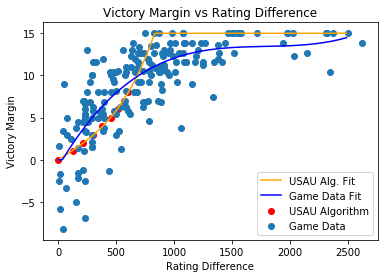

In [411]:
# Start with USAU algorithm data 
# (Assume winner gets 15 points)
usau_victory_margin = np.array([0, 1,   2,   3,   4,   5,   6,   7,   8])
usau_rating_diff =    np.array([0, 125, 214, 300, 381, 454, 515, 565, 600])

game_to = 15

# Fit function
usau_rating_diff_to_victory_margin = get_poly_function_rating_diff_to_victory_margin(usau_rating_diff, usau_victory_margin, game_to=game_to)

# Plot results
usau_rating_diff_full = np.arange(0,2500,10)

data_rating_diff_to_victory_margin = get_poly_function_rating_diff_to_victory_margin(full_results[full_results['RatingDiff']>=0].dropna()['RatingDiff'].values, 
                                                                                     full_results[full_results['RatingDiff']>=0].dropna()['GameTo15VictoryMargin'].values, 
                                                                                     game_to=game_to, poly_degree=3)  
plt.figure()
plt.scatter(rating_diff, victory_margin, marker='o', color='red', label='USAU Algorithm')
plt.scatter(full_results[full_results['RatingDiff']>=0]['RatingDiff'], full_results[full_results['RatingDiff']>=0]['GameTo15VictoryMargin'], label='Game Data')
plt.plot(usau_rating_diff_full, usau_rating_diff_to_victory_margin(rating_diff_full), 
         label='USAU Alg. Fit', color='orange')
plt.plot(usau_rating_diff_full, data_rating_diff_to_victory_margin(rating_diff_full), 
         label='Game Data Fit', color='blue')

plt.xlabel('Rating Difference')
plt.ylabel('Victory Margin')
plt.title('Victory Margin vs Rating Difference')
plt.legend()
plt.show()

In [364]:
data_rating_diff_to_victory_margin = get_poly_function_rating_diff_to_victory_margin([1, 2, 3, 5, 7, 9],[0,3,6,12,16,29], 
                                                                                     game_to=game_to)

In [369]:
data_rating_diff_to_victory_margin = \
  get_poly_function_rating_diff_to_victory_margin(full_results.dropna()['RatingDiff'].values, 
                                                  full_results.dropna()['GameTo15VictoryMargin'].values, 
                                                  game_to=game_to)